In [102]:
from cmath import nan
#from matplotlib.patches import Polygon
import overpy
import OSMPythonTools.api as osm
import shapely.geometry as geometry
from shapely.ops import nearest_points
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt
import sys
import requests
from xml.etree import ElementTree
import numpy as np
import geopy.distance
from coords_to_waypoints import coords_to_waypoints
#from skspatial.objects import Line
#from skspatial.objects import Point


In [103]:

OSM_URL = "https://www.openstreetmap.org/api/0.6/way/{}/relations"
AREA_TERRAIN_TAGS = ['landuse','leisure','natural','public_transport','service']
AREA_BARRIER_TAGS = ['barrier','building','amenity']
NOT_AREA_BARRIER_VALUES = ['parking']
HIGHWAY_TAGS = ['highway','surface']
BARRIER_TAGS = ['waterway','barrier','man_made','building']
TAGS_KEY_ONLY = ['building']
OBSTACLE_TAGS = ['historic','amenity','natural']
NOT_OBSTACLE_TAGS = ['addr:country','addr:street']

class PointInformation():
    terrain = set()
    inside_barrier = []
    highways = []
    barriers = []
    obstacles = []

    def __str__(self):
        s = ""
        if self.terrain:
            s += "{}\n".format(repr(self.terrain))
        else:
            s += "unknown terrain\n"

        if self.highways:
            for h in self.highways:
                s += "nearest road   : {} at {} m\n".format(h[0:-1], h[-1])
        else:
            s += "no near (10 m) roads\n"

        if self.barriers:
            for b in self.barriers:
                s += "nearest barrier: {} at {} m\n".format(b[0:-1], b[-1])
        else:
            s += "no near (10 m) barriers\n"

        if self.inside_barrier:
            s += "POINT INSIDE BARRIER: {}\n".format(self.inside_barrier)
        else:
            s += "point is outside\n"
        
        if self.obstacles:
            for h in self.obstacles:
                s += "nearest obstacle   : {} at {} m\n".format(h[0:-1], h[-1])
        else:
            s += "no near (10 m) obstacles\n"

        return s
        
class SuperWay:
    def __init__(self):
        self.nodes = []
        self.id = 0
        self.tags = {}

class Highway(SuperWay):
    def __init__(self):
        super().__init__()
        self.line = geometry.LineString

    def get_lower_bound(self):
        return self.line.bounds[0:2]
    
    def get_upper_bound(self):
        return self.line.bounds[2:4]

class Area(SuperWay):
    def __init__(self):
        super().__init__()
        self.relations = []
        self.relations_checked = False
        self.polygon = geometry.Polygon
        self.is_barrier = False

class Barrier(Highway):
    def __init__(self):
        super().__init__()    

class Obstacle(SuperWay):
    def __init__(self):
        self.point = geometry.Point()
        self.id = 0
        self.tags = {}


In [104]:

class PathAnalysis:
    def __init__(self, in_file):
        self.api = overpy.Overpass()
        self.waypoints = np.genfromtxt(in_file, delimiter=',')
        self.max_lat = np.max(self.waypoints[:,0])
        self.min_lat = np.min(self.waypoints[:,0])
        self.max_long = np.max(self.waypoints[:,1])
        self.min_long = np.min(self.waypoints[:,1])
        self.points = list(map(geometry.Point, zip(self.waypoints[:,0], self.waypoints[:,1])))
        self.obstacles = []
        
    def get_barrier_areas(self):
        barrier_areas = []
        for area in self.areas:
            if any(tag in area.tags for tag in AREA_BARRIER_TAGS):
                barrier_areas.append(area)
        return barrier_areas

    def get_way_query(self):
        query = """(way({}, {}, {}, {});
                    >;
                    );
                    out;""".format(self.min_lat,self.min_long,self.max_lat,self.max_long)

        return query
    
    def get_node_query(self):
        query = """[bbox:{}, {}, {}, {}];
                    rel; > -> .r;
                    way; > -> .w;
                    ((node; - node.r; ); - node.w; );
                    out;""".format(self.min_lat,self.min_long,self.max_lat,self.max_long)

        return query

    def parse_ways(self):
        # https://gis.stackexchange.com/questions/259422/how-to-get-a-multipolygon-object-from-overpass-ql
        
        areas = []
        highways = []
        barriers = []

        for way in self.osm_ways_data.ways:
            coords = []
            
            try:
                
                """ Get tags from relations of the way. """
                url = OSM_URL.format(way.id)
                r = requests.get(url)
                try:
                    data = ElementTree.fromstring(r.content.decode("utf-8"))
                    relations = data.findall('relation')
                    r_tags = []
                    for relation in relations:
                        print(way.id)
                        r_tags = relation.findall('tag')
                        r_members = relation.findall('member')
                        r_members_in_out = [member.attrib['role'] for member in r_members]
                        r_members_ids = [int(member.attrib['ref']) for member in r_members]
                        current_way_index = r_members_ids.index(way.id) 
                        if r_members_in_out[current_way_index] == "outer":
                            for tag in r_tags:
                                key = tag.attrib['k']
                                value = tag.attrib['v']
                                way.tags[key] = value
                except: continue  

                for node in way.nodes:
                    coords.append([node.lat,node.lon])
                
                if coords[0] == coords[-1]:
                    classified = False

                    if any(tag in AREA_TERRAIN_TAGS for tag in way.tags):
                        area = Area()
                        area.id = way.id
                        area.nodes = way.nodes
                        area.tags = way.tags
                        area.polygon = geometry.Polygon(coords)
                        classified = True
                        areas.append(area)
                    
                    elif any(tag in HIGHWAY_TAGS for tag in way.tags):
                        highway = Highway()       
                        highway.id = way.id
                        highway.nodes = way.nodes
                        highway.tags = way.tags
                        highway.line = geometry.LineString(coords)
                        highways.append(highway)

                    elif any(np.logical_and([tag in AREA_BARRIER_TAGS for tag in way.tags], [value not in NOT_AREA_BARRIER_VALUES for value in list(way.tags.values())])):
                        area = Area()
                        area.id = way.id
                        area.nodes = way.nodes
                        area.tags = way.tags
                        area.polygon = geometry.Polygon(coords)
                        area.is_barrier = True
                        classified = True
                        areas.append(area)
                
                    if not classified:
                        area = Area()
                        area.id = way.id
                        area.nodes = way.nodes
                        area.tags = way.tags
                        area.polygon = geometry.Polygon(coords)
                        areas.append(area)
                        with open("unclassified_tags.txt",'a+') as uncl_f:
                            uncl_f.write("area "+str(way.tags)+"\n")

                elif any(tag in HIGHWAY_TAGS for tag in way.tags):
                    highway = Highway()       
                    highway.id = way.id
                    highway.nodes = way.nodes
                    highway.tags = way.tags
                    highway.line = geometry.LineString(coords)
                    highways.append(highway)

                elif any(tag in BARRIER_TAGS for tag in way.tags):
                    barrier = Barrier()
                    barrier.id = way.id
                    barrier.nodes = way.nodes
                    barrier.tags = way.tags
                    barrier.line = geometry.LineString(coords)
                    barriers.append(barrier)
                else:
                    with open("unclassified_tags.txt",'a+') as uncl_f:
                        uncl_f.write("way "+str(way.tags)+"\n")
                                          
            except: continue

        return areas,highways,barriers       

    def parse_nodes(self):
        obstacles = []

        for node in self.osm_nodes_data.nodes:
            if any(np.logical_and([tag in OBSTACLE_TAGS for tag in node.tags],[tag not in NOT_OBSTACLE_TAGS for tag in node.tags])):
                obstacle = Obstacle()
                obstacle.id = node.id
                obstacle.tags = node.tags
                obstacle.point = geometry.Point([node.lat, node.lon])
                obstacles.append(obstacle)
        
        return obstacles
    
    def closest_way(self, ways, point):
        """ Input is a list of ways (Way objects) and a point. """
        lines = [way.line for way in ways]
        distances = np.array([line.distance(point) for line in lines])  # NOT CORRECT. THIS GEOMETRY DOES NOT TAKE INTO CONSIDERATION THAT WE ARE WORKING WITH WGS...
        min_distance = np.amin(distances)
        arg_min_distance = np.argmin(distances)
        closest_hway = ways[arg_min_distance]
        p = geometry.Point(point.bounds[0:2])

        proj = nearest_points(closest_hway.line, p)[0]

        min_distance = geopy.distance.geodesic(p.bounds[0:2],proj.bounds[0:2]).m
        return(closest_hway, round(min_distance,2))
    
    def closest_area(self, areas, point):
        """ Input is a list of ways (Way objects) and a point. """
        lines = [area.polygon for area in areas]
        """ for l in range(len(lines)):
            if lines[l].contains(point):
                return(areas[l], -1) """

        distances = np.array([line.distance(point) for line in lines if not line.contains(point)])  # NOT CORRECT. THIS GEOMETRY DOES NOT TAKE INTO CONSIDERATION THAT WE ARE WORKING WITH WGS...
        min_distance = np.amin(distances)
        arg_min_distance = np.argmin(distances)
        closest_area = areas[arg_min_distance]
        p = geometry.Point(point.bounds[0:2])

        proj = nearest_points(closest_area.polygon, p)[0]

        min_distance = geopy.distance.geodesic(p.bounds[0:2],proj.bounds[0:2]).m
        return(closest_area, round(min_distance,2))
    
    def closest_obstacle(self, obstacles, point):
        distances = [obstacle.point.distance(point) for obstacle in obstacles]
        min_distance = np.amin(distances)
        arg_min_distance = np.argmin(distances)
        closest_obstacle = obstacles[arg_min_distance]
        min_distance = geopy.distance.geodesic(point.bounds[0:2],closest_obstacle.point.bounds[0:2]).m
    
        return(closest_obstacle, round(min_distance,2))
    
    def get_terrain(self):
        
        def parse_tags(tags_to_parse, tags_category):
            tags_to_return = []

            for tag in tags_category:
                if tag in tags_to_parse:
                    if tag in TAGS_KEY_ONLY:
                        tags_to_return.append(tag)
                    else:
                        tags_to_return.append(tags_to_parse[tag])

            return tags_to_return

        terrain = [PointInformation() for i in range(len(self.points))]
        
        for i,point in enumerate(self.points):

            # Find inside which areas the point is.
            for area in self.areas:
                polygon = area.polygon
                still_contains = True
                if polygon.contains(point):
                    if not area.relations_checked:
                        url = OSM_URL.format(area.id)
                        r = requests.get(url)
                        try:
                            data = ElementTree.fromstring(r.content.decode("utf-8"))
                            relations = data.findall('relation')
                            r_tags = []
                            for relation in relations:
                                print(area.id)
                                r_tags = relation.findall('tag')
                                r_members = relation.findall('member')
                                r_members_in_out = [member.attrib['role'] for member in r_members]
                                r_members_ids = [int(member.attrib['ref']) for member in r_members]
                                current_area_index = r_members_ids.index(area.id) 
                                inner_area_indices = [ind for ind in range(len(r_members_in_out)) if r_members_in_out[ind] == "inner"]
                                inner_area_ids = [r_members_ids[ind] for ind in inner_area_indices]
                                if r_members_in_out[current_area_index] == "outer":
                                    if "inner" in r_members_in_out:
                                        area.polygon = geometry.Polygon(area.polygon.exterior.coords, [inner_area.polygon.exterior.coords for inner_area in self.areas if inner_area.id in inner_area_ids])                       
                                    
                                    for tag in r_tags:
                                        key = tag.attrib['k']
                                        value = tag.attrib['v']
                                        area.tags[key] = value
                                    print(area.id)
                                    print(area.tags)
                                    
                                    if not polygon.contains(point):
                                        still_contains = False
                        except Exception as e:
                            print(e)
                            pass
                        area.relations_checked = True

                    # Get terrain of the area.
                    if still_contains:
                        terrain[i].terrain = terrain[i].terrain.union(set(parse_tags(area.tags, AREA_TERRAIN_TAGS)))
                        terrain[i].inside_barrier = terrain[i].inside_barrier + parse_tags(area.tags, AREA_BARRIER_TAGS)
                    still_contains = True

            # Find nearest highway (path,road,sidewalk...).
            if self.highways:
                closest_highway,dist = self.closest_way(self.highways, point)
                
                if dist < 10:
                    highway_n_dist = parse_tags(closest_highway.tags, HIGHWAY_TAGS)+[str(dist)]
                    terrain[i].highways = terrain[i].highways + [highway_n_dist]

            # Find nearest area barrier (fenced area, building).
            barrier_areas = self.get_barrier_areas()
            if barrier_areas:
                closest_area_barrier,dist = self.closest_area(barrier_areas, point)

                if dist < 10:
                    area_barrier_n_dist = parse_tags(closest_area_barrier.tags, AREA_BARRIER_TAGS)+[str(dist)]
                    terrain[i].barriers = terrain[i].barriers + [area_barrier_n_dist]

            # Find nearest barrier (waterway,).
            if self.barriers:
                closest_barrier,dist = self.closest_way(self.barriers, point)
                
                if dist < 10:
                    barrier_n_dist = parse_tags(closest_barrier.tags, BARRIER_TAGS)+[str(dist)]
                    terrain[i].barriers = terrain[i].barriers + [barrier_n_dist]
        
            if self.obstacles:
                closest_obstacle,dist = self.closest_obstacle(self.obstacles, point)

                if dist < 10:
                    obstacle_n_dist = parse_tags(closest_obstacle.tags, OBSTACLE_TAGS)+[str(dist)]
                    terrain[i].obstacles = terrain[i].obstacles + [obstacle_n_dist]

        return terrain

    def plot(self):
        fig,ax = plt.subplots(figsize=(24, 18), dpi=200)
        xys = []

        for area in self.areas:
            x,y = area.polygon.exterior.xy
            xys.append([x,y,area.is_barrier])

        for way in xys:
            if way[2]:
                ax.plot(way[1], way[0], c='red')
            else:
                ax.plot(way[1], way[0], c='blue')

        xys = []
        
        for highway in self.highways:
            x,y = highway.line.xy
            xys.append([x,y])

        for way in xys:
            ax.plot(way[1], way[0], c='cyan')

        xys = []
        
        for barrier in self.barriers:
            x,y = barrier.line.xy
            xys.append([x,y])

        for way in xys:
            ax.plot(way[1], way[0], c='red')

        if self.obstacles:
            obstacle_coords = np.array([[obstacle.point.x,obstacle.point.y] for obstacle in self.obstacles])
            ax.scatter(obstacle_coords[:,1], obstacle_coords[:,0], c='red', s=10)
        
        ax.scatter(self.waypoints[:,1],self.waypoints[:,0], c='green', s=10)
        ax.set_xlim(self.min_long-(self.max_long-self.min_long)*0.2, self.max_long+(self.max_long-self.min_long)*0.2)
        ax.set_ylim(self.min_lat-(self.max_lat-self.min_lat)*0.2, self.max_lat+(self.max_lat-self.min_lat)*0.2)
        plt.show()


In [105]:
coords_to_waypoints()
in_file = "waypoints.csv"
path_analysis = PathAnalysis(in_file)

way_query = path_analysis.get_way_query()
osm_ways_data = path_analysis.api.query(way_query)

#node_query = path_analysis.get_node_query()
#osm_nodes_data = path_analysis.api.query(node_query)

print("queries complete")


Generated 67 waypoints from 20 coordinate pairs.
queries complete


In [106]:
path_analysis = PathAnalysis(in_file)

path_analysis.way_query = way_query
path_analysis.osm_ways_data = osm_ways_data

#path_analysis.node_query = node_query
#path_analysis.osm_nodes_data = osm_nodes_data

4083702
4083702
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4323227
4415011
4641277
4690286
4690286
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
10157973
25921019
26306946
27449046
27449046
27449046
27753990
27754043
27804641
27807038
27807038
30745998
30745998
30986188
30986188
30986191
30986199
34170016
34170022
35832873
35832888
35832889
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770904
111770907
111770910
111770910
111770910
127409922
127409922
127409922
127409922
127909420
150818811
288442957
333597254
333597254
333597254
333597254
333597254
333597254
333597254
333597254
333597254
333597254
333597254
333

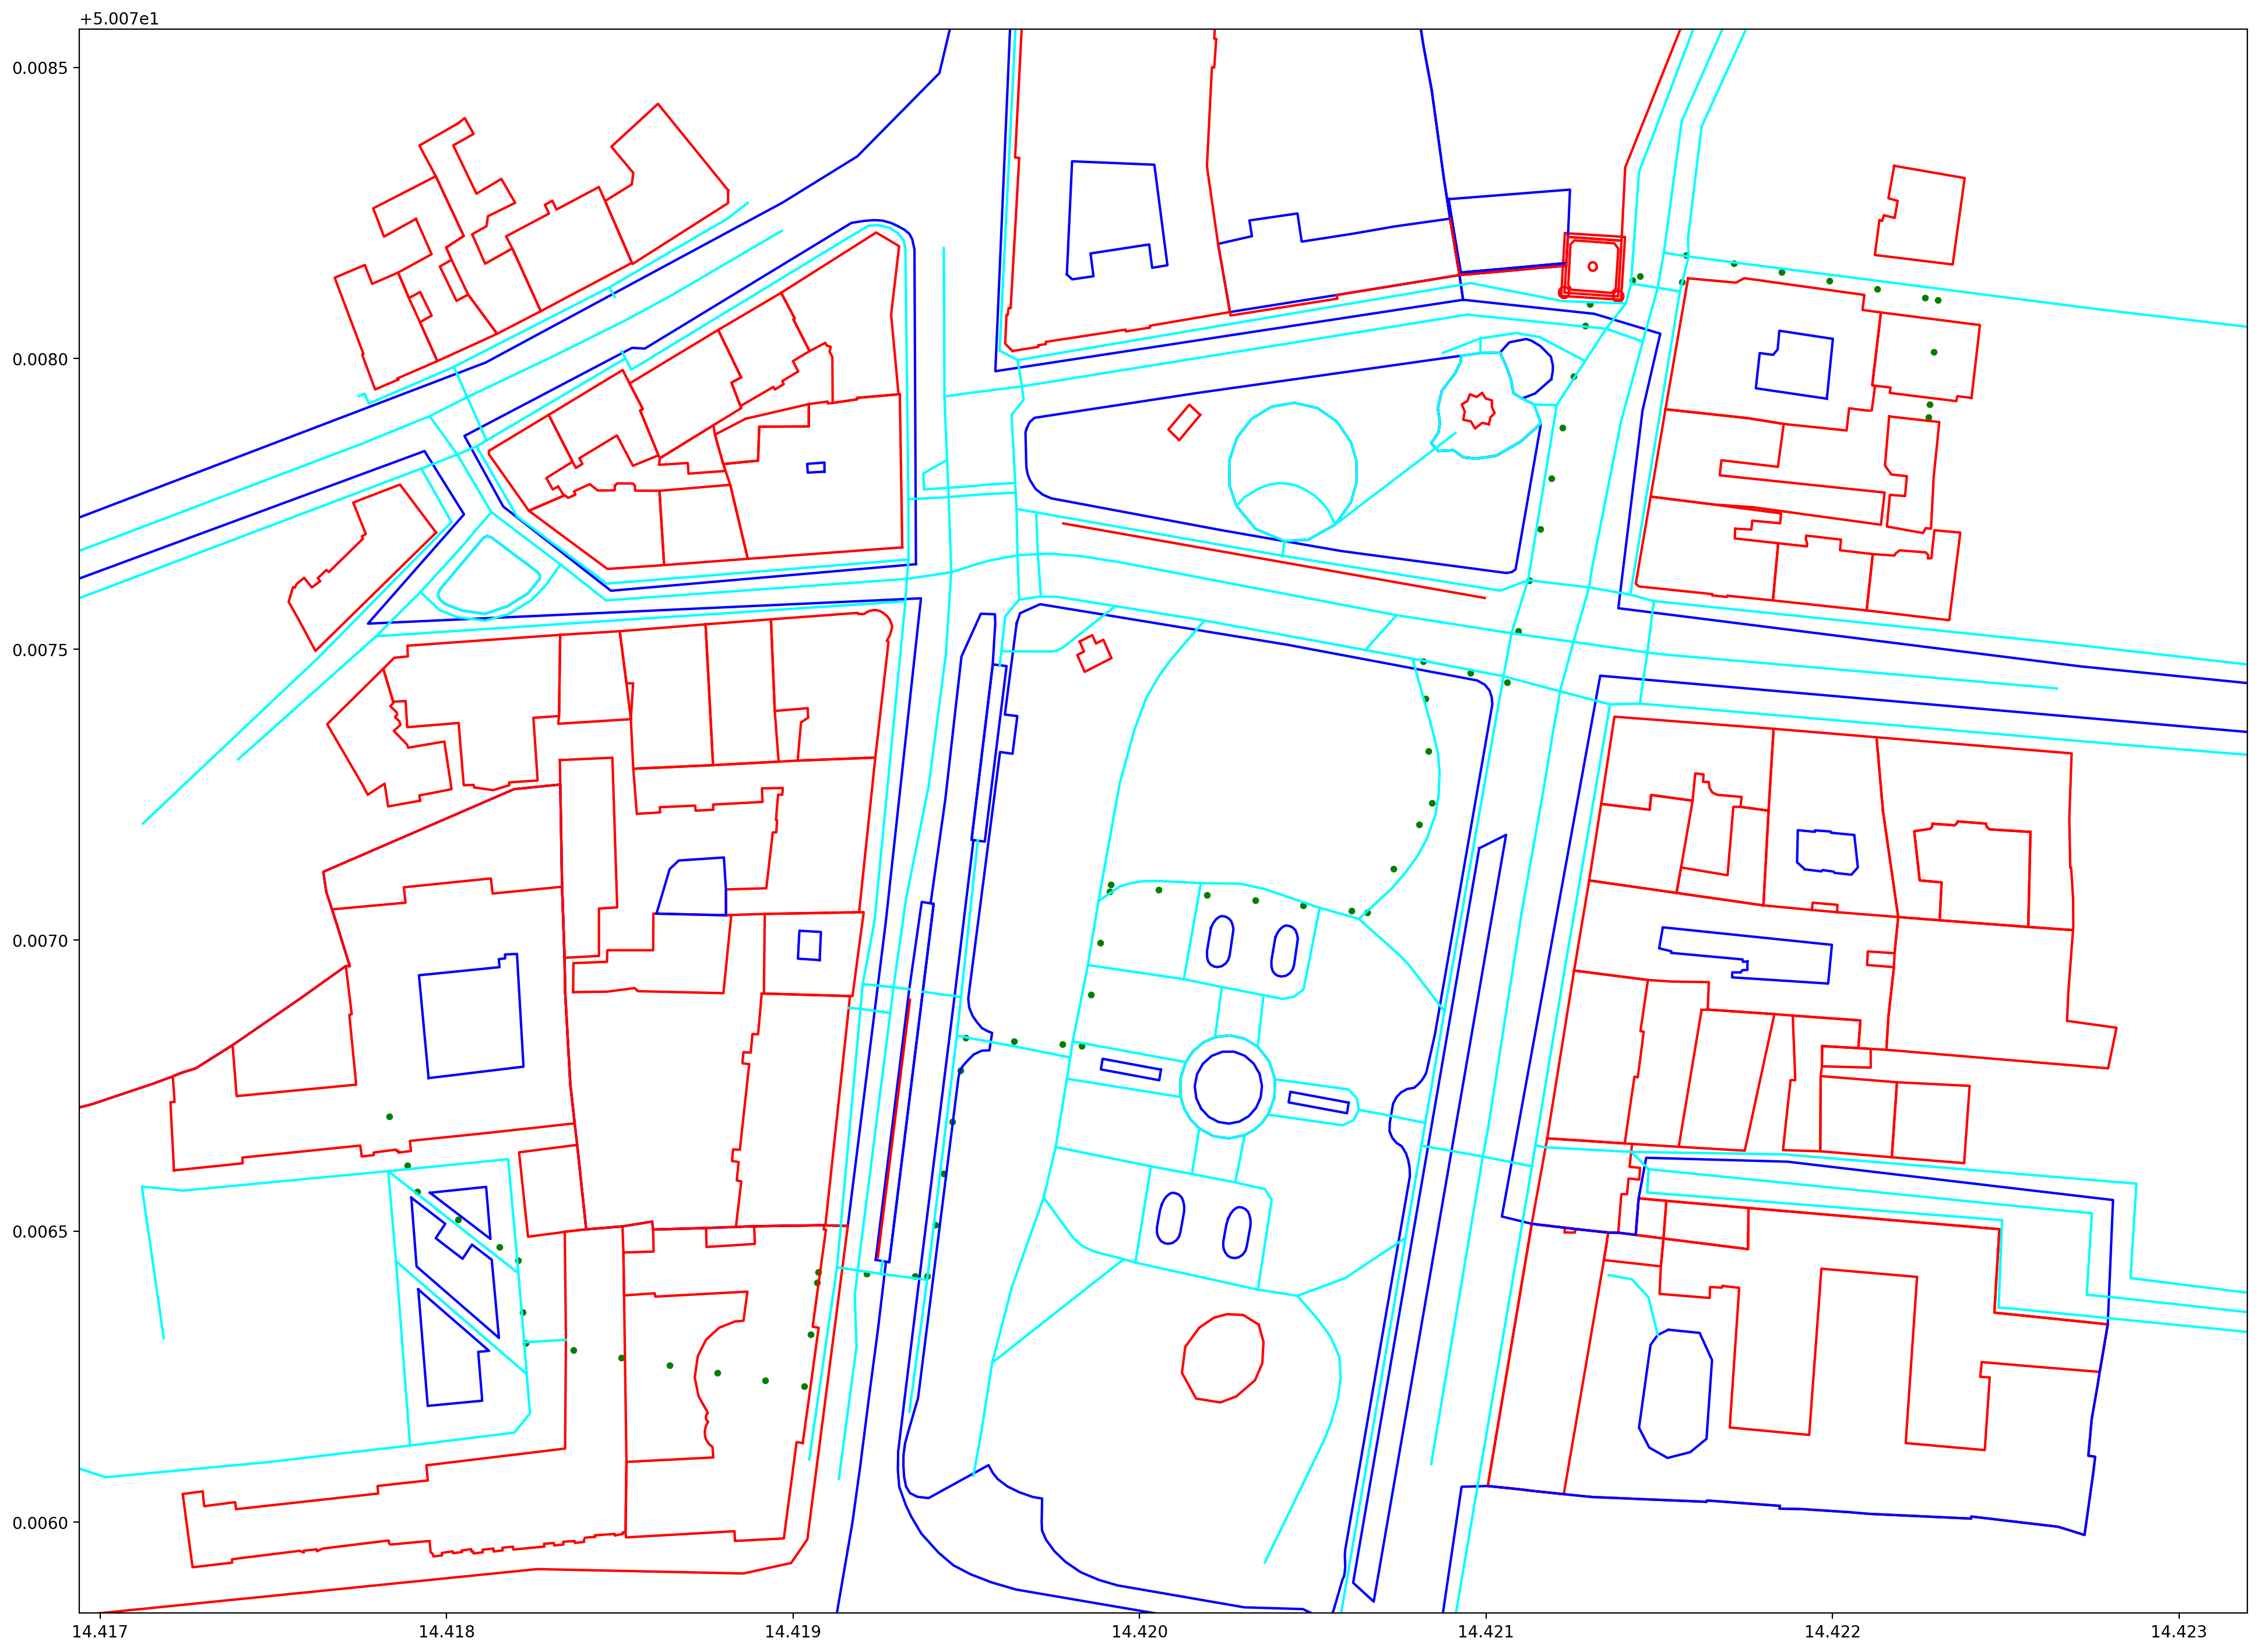

In [107]:

path_analysis.areas, path_analysis.highways, path_analysis.barriers = path_analysis.parse_ways()
#path_analysis.obstacles = path_analysis.parse_nodes()

path_analysis.terrain = path_analysis.get_terrain()
with open("path_analysis.txt",'w+') as f:
    for line in path_analysis.terrain:
        f.write(line.__str__())
        f.write("\n")

path_analysis.plot()